In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint, uniform
from sklearn.svm import SVC
import joblib
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, GRU
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_csv("CDC_Data/clean_data1.csv", low_memory=False)

Mounted at /content/drive


In [3]:
relevant_cat_features =  ['race',
 'education_level',
 'birth_place',
 'Gender',
 'asthma',
 'asthma_currently',
 'hay_fever',
 'anemia',
 'ever_overweight',
 'arthritis',
 'heart_failure',
 'heart_disease',
 'angina',
 'heart_attack',
 'stroke',
 'thyroid_problem',
 'thyroid_problem_currently',
 'liver_condition',
 'liver_condition_currently',
 'cancer',
 'asthma_relative',
 'diabetes_relative',
 'heart_attack_relative',
 'work_type',
 'trouble_sleeping_history',
 'vigorous_recreation',
 'moderate_recreation',
 'moderate_work',
 'lifetime_alcohol_consumption']

In [4]:
df.iloc[:,:38].columns

Index(['race', 'education_level', 'birth_place', 'Gender', 'asthma',
       'asthma_currently', 'hay_fever', 'anemia', 'ever_overweight',
       'arthritis', 'heart_failure', 'heart_disease', 'angina', 'heart_attack',
       'stroke', 'thyroid_problem', 'thyroid_problem_currently',
       'liver_condition', 'liver_condition_currently', 'cancer',
       'asthma_relative', 'diabetes_relative', 'heart_attack_relative',
       'work_type', 'trouble_sleeping_history', 'vigorous_recreation',
       'moderate_recreation', 'moderate_work', 'lifetime_alcohol_consumption',
       'Age_in_years', 'height', 'weight', 'sleep_hours', 'sedentary_time',
       'drinks_per_occasion', 'drinks_past_year', 'current_cigarettes_per_day',
       'prescriptions_count'],
      dtype='object')

In [5]:
X = df.drop(columns={'depression'})
y = df['depression']

In [6]:
# Encoding the categorical features using LabelEncoder()
label_encoders = {}
for feature in relevant_cat_features:
    label_encoders[feature] = LabelEncoder()

X_preprocessed = X.copy()
for feature in relevant_cat_features:
    X_preprocessed[feature] = label_encoders[feature].fit_transform(X[feature])

In [7]:
# Standardize the features using Standardscaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preprocessed)

n_features = X_scaled.shape[1]

explained_variance_ratios = []
n_components_range = range(1, n_features + 1)

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))
optimal_n_components = np.argmax(explained_variance_ratios) + 1
print("Optimal number of components:", optimal_n_components)

pca = PCA(n_components=optimal_n_components)
X_pca = pca.fit_transform(X_scaled)

Optimal number of components: 201


In [8]:
# Train/test data
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Best parameters:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.7620578778135049
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      5658
           1       0.25      0.75      0.38       559

    accuracy                           0.78      6217
   macro avg       0.61      0.77      0.62      6217
weighted avg       0.90      0.78      0.82      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1408
           1       0.23      0.65      0.34       147

    accuracy                           0.76      1555
   macro avg       0.59      0.71      0.60      1555
weighted avg       0.89      0.76      0.81      1555


Percentage Prediction for Test Data:
Row 1: Not depressed: 74.57%, Depressed: 25.43%
Row 2: Not depressed: 42.09%, Depressed: 57.91%
Row 3: Not depressed

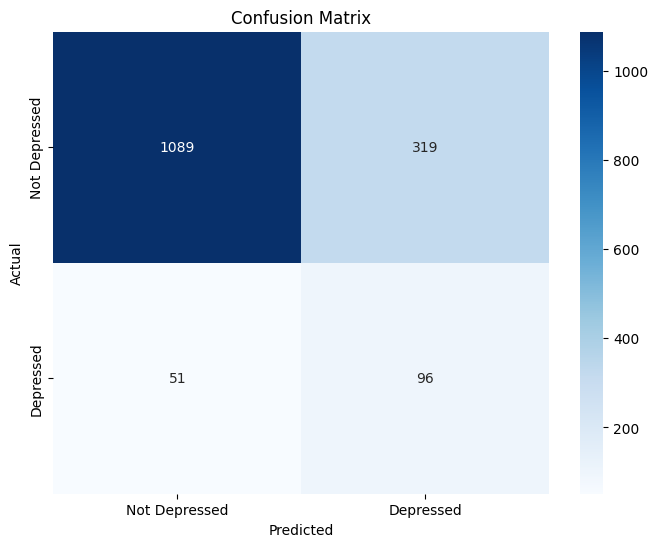

In [9]:
# Logistic Regression model
logistic_regression = LogisticRegression(random_state=42, class_weight = 'balanced')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5)
grid_search.fit(X_train_preprocessed, y_train)

best_logistic_regression = grid_search.best_estimator_


y_train_proba = best_logistic_regression.predict_proba(X_train_preprocessed)
y_test_proba = best_logistic_regression.predict_proba(X_test_preprocessed)

threshold = 0.5

y_train_pred = (y_train_proba[:, 1] >= threshold).astype(int)
y_test_pred = (y_test_proba[:, 1] >= threshold).astype(int)
print("Best parameters: ", grid_search.best_params_)
test_accuracy = best_logistic_regression.score(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nPercentage Prediction for Test Data:")
for i in range(len(X_test_preprocessed)):
    print(f"Row {i + 1}: Not depressed: {y_test_proba[i, 0] * 100:.2f}%, Depressed: {y_test_proba[i, 1] * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      5658
           1       0.20      0.60      0.30       559

    accuracy                           0.75      6217
   macro avg       0.57      0.68      0.57      6217
weighted avg       0.88      0.75      0.80      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1408
           1       0.17      0.53      0.26       147

    accuracy                           0.71      1555
   macro avg       0.55      0.63      0.54      1555
weighted avg       0.86      0.71      0.77      1555



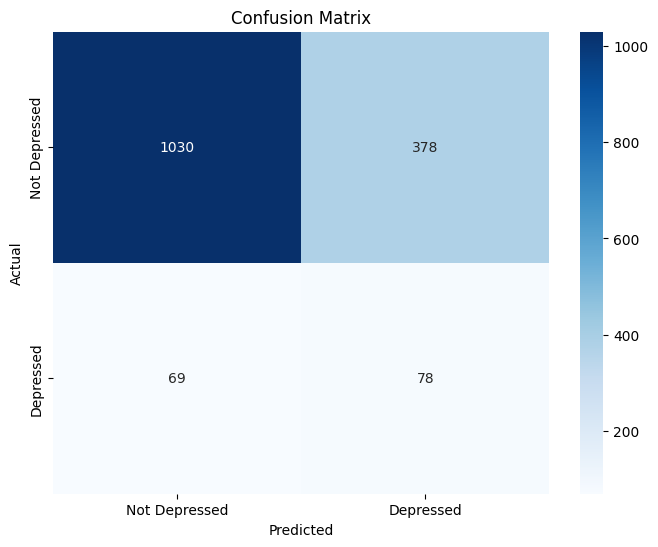

In [ ]:
# DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_preprocessed, y_train)

best_dt_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

y_train_pred_proba = best_dt_model.predict_proba(X_train_preprocessed)[:, 1]
y_test_pred_proba = best_dt_model.predict_proba(X_test_preprocessed)[:, 1]

threshold = 0.6
y_train_pred = (y_train_pred_proba >= threshold).astype(int)
y_test_pred = (y_test_pred_proba >= threshold).astype(int)
print("Best parameters: ", grid_search.best_params_)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# RandomForestClassifier
rf_classifier = RandomForestClassifier()
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_preprocessed, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_rf_model = random_search.best_estimator_

print("Best Model:", best_rf_model)

rf_probabilities = best_rf_model.predict_proba(X_test_preprocessed)

rf_percentages = [f"{round(prob[1] * 100, 2)}% depressed, {round(prob[0] * 100, 2)}% not depressed" for prob in rf_probabilities]
for i, percentage in enumerate(rf_percentages):
    print(f"Input {i + 1}: {percentage}")

y_train_pred = best_rf_model.predict(X_train_preprocessed)
rf_y_pred = best_rf_model.predict(X_test_preprocessed)
accuracy = accuracy_score(y_test, rf_y_pred)

print("Accuracy:", accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, rf_y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Best Hyperparameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 610}
Best Model: RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=610)
Input 1: 1.99% depressed, 98.01% not depressed
Input 2: 13.51% depressed, 86.49% not depressed
Input 3: 27.54% depressed, 72.46% not depressed
Input 4: 7.1% depressed, 92.9% not depressed
Input 5: 5.42% depressed, 94.58% not depressed
Input 6: 26.29% depressed, 73.71% not depressed
Input 7: 8.34% depressed, 91.66% not depressed
Input 8: 25.85% depressed, 74.15% not depressed
Input 9: 5.0% depressed, 95.0% not depressed
Input 10: 15.42% depressed, 84.58% not depressed
Input 11: 10.14% depressed, 89.86% not depressed
Input 12: 7.81% depressed, 92.19% not depressed
Input 13: 11.13% depressed, 88.87% not depressed
Input 14: 16.5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Test Accuracy: 0.9054662379421222
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5658
           1       1.00      1.00      1.00       559

    accuracy                           1.00      6217
   macro avg       1.00      1.00      1.00      6217
weighted avg       1.00      1.00      1.00      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1408
           1       0.20      0.52      0.28       147

    accuracy                           0.75      1555
   macro avg       0.57      0.65      0.57      1555
weighted avg       0.87      0.75      0.80      1555



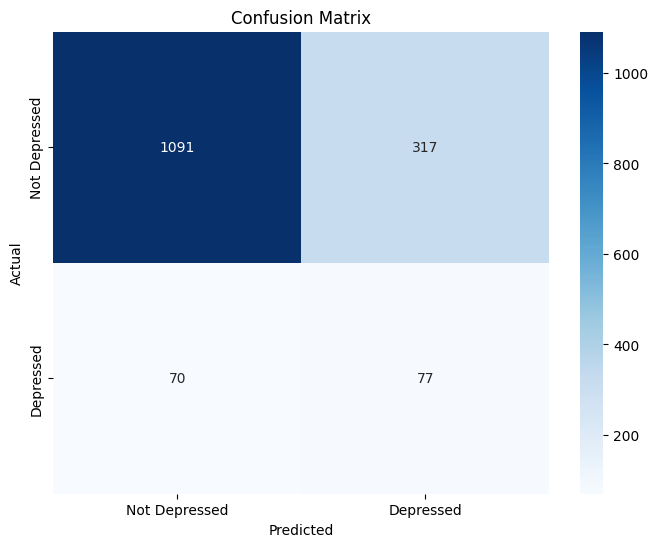

In [62]:
# KNNClassifier
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
             }

random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=80, scoring='accuracy', cv=7, random_state=42)
random_search.fit(X_train_preprocessed, y_train)
knn_model = random_search.best_estimator_

test_accuracy = knn_model.score(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)

y_train_proba = knn_model.predict_proba(X_train_preprocessed)[:, 1]
y_test_proba = knn_model.predict_proba(X_test_preprocessed)[:, 1]
thresholds = np.linspace(0, 1, 100)

best_threshold = None
best_f1_score = 0

for threshold in thresholds:
    y_train_pred = (y_train_proba >= threshold).astype(int)
    y_test_pred = (y_test_proba >= threshold).astype(int)
    train_f1_score = f1_score(y_train, y_train_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    if test_f1_score > best_f1_score:
        best_threshold = threshold
        best_f1_score = test_f1_score

y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [63]:
random_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}

Accuracy: 0.8392282958199357
Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5658
           1       0.18      0.16      0.17       559

    accuracy                           0.86      6217
   macro avg       0.55      0.54      0.55      6217
weighted avg       0.85      0.86      0.86      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1408
           1       0.17      0.18      0.18       147

    accuracy                           0.84      1555
   macro avg       0.54      0.55      0.54      1555
weighted avg       0.84      0.84      0.84      1555



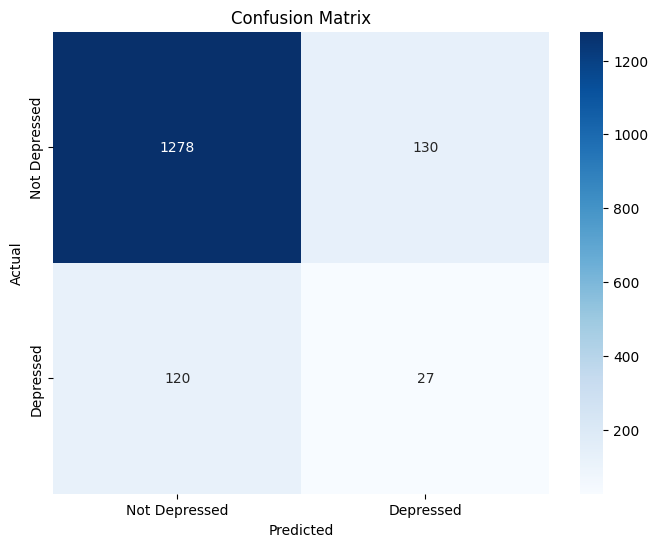

In [64]:
# Gaussian Naive Bayes classifier
nb = GaussianNB(priors=class_priors)
class_counts = y_train.value_counts()
class_priors = class_counts / len(y_train)
nb.fit(X_train_preprocessed, y_train)

accuracy = nb.score(X_test_preprocessed, y_test)
print("Accuracy:", accuracy)
y_train_pred = nb.predict(X_train_preprocessed)
y_test_pred = nb.predict(X_test_preprocessed)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# SVC model
svc = SVC(class_weight='balanced', random_state=42)

param_grid = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['linear']
}
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1', random_state=42)
random_search.fit(X_train_preprocessed, y_train)
best_svc = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", random_search.best_score_)

test_accuracy = best_svc.score(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)

y_train_pred = best_svc.predict(X_train_preprocessed)
y_test_pred = best_svc.predict(X_test_preprocessed)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'C': 0.155221171236024, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.3141111336477108
Test Accuracy: 0.7491961414790996
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      5658
           1       0.25      0.75      0.37       559

    accuracy                           0.77      6217
   macro avg       0.61      0.76      0.62      6217
weighted avg       0.90      0.77      0.82      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1408
           1       0.22      0.63      0.32       147

    accuracy                           0.75      1555
   macro avg       0.58      0.70      0.58      1555
weighted avg       0.88      0.75      0.80      1555



Model saved successfully at: /content/drive/MyDrive/CDC_Data/best_svc_model1.pkl
Test Accuracy: 0.7491961414790996
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      5658
           1       0.25      0.75      0.37       559

    accuracy                           0.77      6217
   macro avg       0.61      0.76      0.62      6217
weighted avg       0.90      0.77      0.82      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1408
           1       0.22      0.63      0.32       147

    accuracy                           0.75      1555
   macro avg       0.58      0.70      0.58      1555
weighted avg       0.88      0.75      0.80      1555



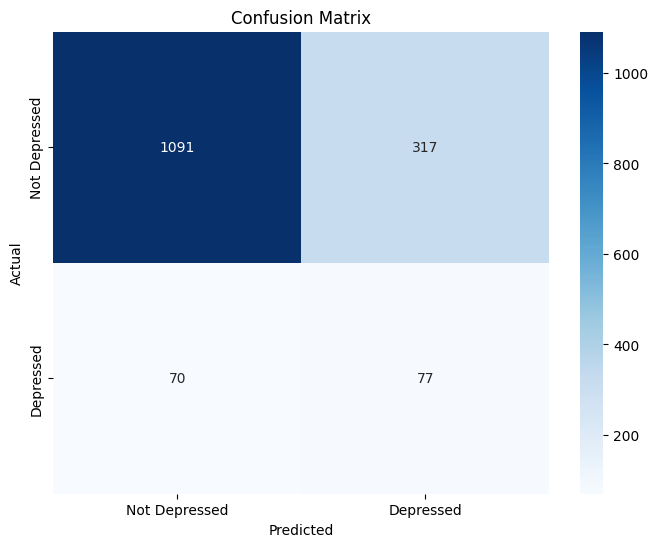

In [ ]:

test_accuracy = best_svc.score(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)

y_train_pred = best_svc.predict(X_train_preprocessed)
y_test_pred = best_svc.predict(X_test_preprocessed)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Gradient Boosting Classifier
gboost_base_model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.75, 1.0]
}
random_search = RandomizedSearchCV(estimator=gboost_base_model, param_distributions=param_grid, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_preprocessed, y_train)

print("Best Hyperparameters:", random_search.best_params_)
best_gboost_model = random_search.best_estimator_
gboost_probabilities = best_gboost_model.predict_proba(X_test_preprocessed)

gboost_percentages = [f"{round(prob[1] * 100, 2)}% depressed, {round(prob[0] * 100, 2)}% not depressed" for prob in gboost_probabilities]
for i, percentage in enumerate(gboost_percentages):
    print(f"Input {i + 1}: {percentage}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.01}
Input 1: 5.52% depressed, 94.48% not depressed
Input 2: 8.12% depressed, 91.88% not depressed
Input 3: 7.0% depressed, 93.0% not depressed
Input 4: 5.59% depressed, 94.41% not depressed
Input 5: 7.5% depressed, 92.5% not depressed
Input 6: 21.28% depressed, 78.72% not depressed
Input 7: 7.38% depressed, 92.62% not depressed
Input 8: 6.33% depressed, 93.67% not depressed
Input 9: 7.46% depressed, 92.54% not depressed
Input 10: 9.18% depressed, 90.82% not depressed
Input 11: 6.51% depressed, 93.49% not depressed
Input 12: 4.94% depressed, 95.06% not depressed
Input 13: 5.95% depressed, 94.05% not depressed
Input 14: 15.83% depressed, 84.17% not depressed
Input 15: 5.24% depressed, 94.76% not depressed
Input 16: 9.5% depressed, 90.5% not depressed
Input 17: 4.95% depressed, 95.05% n

NameError: name 'gboost_y_pred' is not defined

In [65]:
y_train_pred = best_gboost_model.predict(X_train_preprocessed)
y_test_pred = best_gboost_model.predict(X_test_preprocessed)
accuracy = accuracy_score(y_test, y_test_pred)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5658
           1       1.00      0.19      0.32       559

    accuracy                           0.93      6217
   macro avg       0.96      0.59      0.64      6217
weighted avg       0.93      0.93      0.90      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1408
           1       0.00      0.00      0.00       147

    accuracy                           0.91      1555
   macro avg       0.45      0.50      0.48      1555
weighted avg       0.82      0.91      0.86      1555



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# FCNN model
model = Sequential()
model.add(Dense(256, input_dim=X_train_preprocessed.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)

class_weights = dict(enumerate(class_weights))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51712     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 183810 (718.01 KB)
Trainable params: 183810 (718.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
195/195 [==============================] - 2s 7ms/step - loss: 0.6969 - accuracy: 0.3011 - val_loss: 0.7314 - val_accuracy: 0.5273
Epoch 2/10
195/195 [==============================] - 1s 5ms/step - loss: 0.6552 - accuracy: 0.5816 - val_loss: 0.7109 - val_accuracy: 0.6212
Epoch 3/10
195/195 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6817 - val_loss: 0.6741 - val_accuracy: 0.6810
Epoch 4/10
195/195 [==============================] - 1s 5ms/step - loss: 0.6100 - accuracy: 0.7084 - val_loss: 0.6343 - val_accuracy: 0.7125
Epoch 5/10
195/195 [==============================] - 1s 5ms/step - loss: 0.5936 - accuracy: 0.7314 - val_loss: 0.6279 - val_accuracy: 0.7119
Epoch 6/10
195/195 [==============================] - 1s 6ms/step - loss: 0.5787 - accuracy: 0.7412 - val_loss: 0.6124 - val_accuracy: 0.7215
Epoch 7/10
195/195 [==============================] - 1s 5ms/step - loss: 0.5664 - accuracy: 0.7428 - val_loss: 0.5908 - val_accuracy: 0.7260
Epoch 

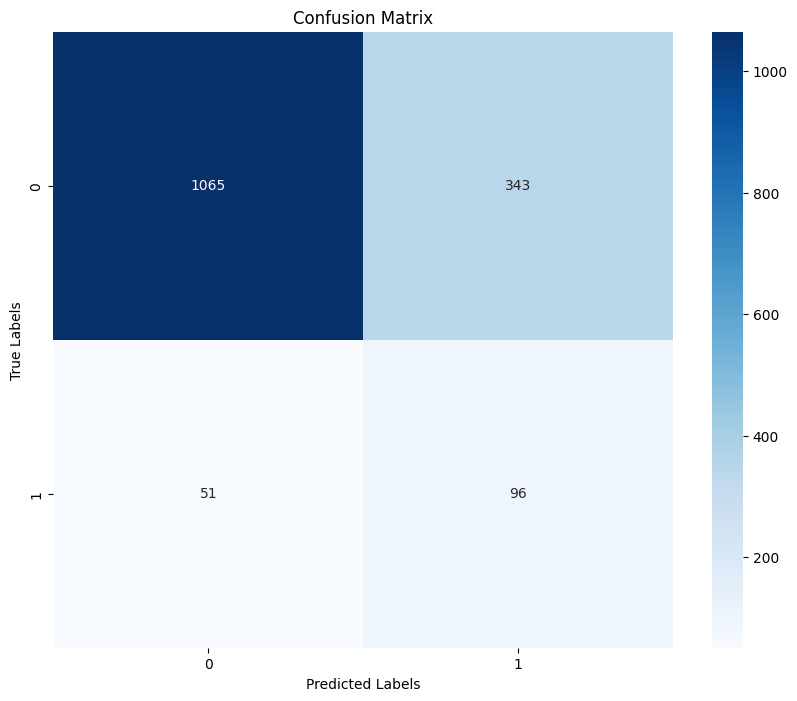

In [ ]:

history = model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, y_test), class_weight=class_weights)

train_predictions = model.predict(X_train_preprocessed)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_accuracy = accuracy_score(y_train, train_predicted_labels)
print("Training Accuracy:", train_accuracy)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_predicted_labels))
test_predictions = model.predict(X_test_preprocessed)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_accuracy = accuracy_score(y_test, test_predicted_labels)
print("\nTest Accuracy:", test_accuracy)
print("\nTest Classification Report:")
print(classification_report(y_test, test_predicted_labels))

cm = confusion_matrix(y_test, test_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [67]:
# RNN model
X_train_reshaped = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_test_reshaped = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], 1))

rnn_model = Sequential()
rnn_model.add(LSTM(256, return_sequences=True, input_shape=(X_train_preprocessed.shape[1], 1)))
rnn_model.add(LSTM(256, return_sequences=True))
rnn_model.add(LSTM(256, return_sequences=True))
rnn_model.add(LSTM(256))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 201, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 201, 256)          525312    
                                                                 
 lstm_2 (LSTM)               (None, 201, 256)          525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1840385 (7.02 MB)
Trainable params: 1840385 (7.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
class_weight = {0: 1, 1: 9}
rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), class_weight=class_weight)

Epoch 1/10
195/195 [==============================] - 814s 4s/step - loss: 1.1922 - accuracy: 0.8266 - val_loss: 0.6237 - val_accuracy: 0.9055
Epoch 2/10
195/195 [==============================] - 645s 3s/step - loss: 1.1905 - accuracy: 0.9101 - val_loss: 0.6633 - val_accuracy: 0.9055
Epoch 3/10
195/195 [==============================] - 636s 3s/step - loss: 1.1896 - accuracy: 0.9099 - val_loss: 0.6613 - val_accuracy: 0.9055
Epoch 4/10
195/195 [==============================] - 636s 3s/step - loss: 1.1897 - accuracy: 0.9101 - val_loss: 0.6592 - val_accuracy: 0.9055
Epoch 5/10
195/195 [==============================] - 686s 4s/step - loss: 1.2039 - accuracy: 0.8342 - val_loss: 0.6302 - val_accuracy: 0.9055
Epoch 6/10
195/195 [==============================] - 653s 3s/step - loss: 1.1953 - accuracy: 0.7930 - val_loss: 0.6425 - val_accuracy: 0.9055
Epoch 7/10
195/195 [==============================] - 629s 3s/step - loss: 1.1952 - accuracy: 0.7811 - val_loss: 0.6185 - val_accuracy: 0.9055

In [70]:
train_predictions = rnn_model.predict(X_train_reshaped)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_predicted_labels)
print("Training Accuracy:", train_accuracy)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_predicted_labels))
predictions = rnn_model.predict(X_test_reshaped)
predicted_labels = (predictions > 0.5).astype(int)
probability_percentages = predictions * 100
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)

195/195 [==============================] - 190s 972ms/step
Training Accuracy: 0.910085250120637

Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5658
           1       0.00      0.00      0.00       559

    accuracy                           0.91      6217
   macro avg       0.46      0.50      0.48      6217
weighted avg       0.83      0.91      0.87      6217



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



49/49 [==============================] - 40s 826ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1408
           1       0.00      0.00      0.00       147

    accuracy                           0.91      1555
   macro avg       0.45      0.50      0.48      1555
weighted avg       0.82      0.91      0.86      1555

Accuracy: 0.9054662379421222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [71]:

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
cnn_model.add(MaxPooling2D((1, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((1, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((1, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((1, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

class_weight = {0: 1, 1: 9}
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), class_weight=class_weight)

X_train_reshaped = X_train_preprocessed.reshape(X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1], 1)
X_test_reshaped = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1], 1)

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 201, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 100, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 100, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 50, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 50, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 25, 64)        

In [72]:
train_predictions = cnn_model.predict(X_train_reshaped)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_predicted_labels)
print("Training Accuracy:", train_accuracy)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_predicted_labels))

y_pred = cnn_model.predict(X_test_reshaped)

accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred.round()))

195/195 [==============================] - 3s 14ms/step
Training Accuracy: 0.910085250120637

Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5658
           1       0.00      0.00      0.00       559

    accuracy                           0.91      6217
   macro avg       0.46      0.50      0.48      6217
weighted avg       0.83      0.91      0.87      6217

 1/49 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



49/49 [==============================] - 1s 20ms/step
Accuracy: 0.7093247588424437
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1408
           1       0.20      0.67      0.30       147

    accuracy                           0.71      1555
   macro avg       0.57      0.69      0.56      1555
weighted avg       0.88      0.71      0.77      1555



In [ ]:
# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(X_train_preprocessed.shape[1], 1)))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gru_model.summary()

X_train_reshaped = X_train_preprocessed.reshape(X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1)
X_test_reshaped = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], 1)

class_weight = {0: 1, 1: 9}
gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), class_weight=class_weight)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 201, 128)          50304     
                                                                 
 gru_1 (GRU)                 (None, 201, 128)          99072     
                                                                 
 gru_2 (GRU)                 (None, 201, 128)          99072     
                                                                 
 gru_3 (GRU)                 (None, 201, 128)          99072     
                                                                 
 gru_4 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 446721 (1.70 MB)
Trainable params: 44672

In [ ]:
train_predictions = gru_model.predict(X_train_reshaped)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_accuracy = accuracy_score(y_train, train_predicted_labels)
print("Training Accuracy:", train_accuracy)
print("\nTraining Classification Report:")
print(classification_report(y_train, train_predicted_labels))
predictions = gru_model.predict(X_test_reshaped)
predicted_labels = (predictions > 0.5).astype(int)
probability_percentages = predictions * 100

print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)

In [ ]:
# Using the stacking classifier
base_classifiers = [
    ('lr', best_logistic_regression),
    ('dt', best_dt_model),
    ('knn', knn_model),
    ('svc', best_svc)
]
meta_classifier = LogisticRegression()
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier
)
stacking_classifier.fit(X_train_preprocessed, y_train)
y_train_pred = stacking_classifier.predict(X_train_preprocessed)

print("Classification Report:")
print(classification_report(y_train, y_train_pred))
y_pred = stacking_classifier.predict(X_test_preprocessed)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5658
           1       0.98      0.10      0.18       559

    accuracy                           0.92      6217
   macro avg       0.95      0.55      0.57      6217
weighted avg       0.92      0.92      0.89      6217

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1408
           1       0.00      0.00      0.00       147

    accuracy                           0.91      1555
   macro avg       0.45      0.50      0.48      1555
weighted avg       0.82      0.91      0.86      1555



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      5658
           1       0.20      0.70      0.31       559

    accuracy                           0.73      6217
   macro avg       0.58      0.71      0.57      6217
weighted avg       0.89      0.73      0.78      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1408
           1       0.19      0.67      0.30       147

    accuracy                           0.70      1555
   macro avg       0.57      0.69      0.55      1555
weighted avg       0.88      0.70      0.76      1555



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      5658
           1       0.23      0.71      0.35       559

    accuracy                           0.76      6217
   macro avg       0.60      0.74      0.60      6217
weighted avg       0.90      0.76      0.81      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1408
           1       0.18      0.56      0.27       147

    accuracy                           0.71      1555
   macro avg       0.56      0.64      0.54      1555
weighted avg       0.87      0.71      0.77      1555



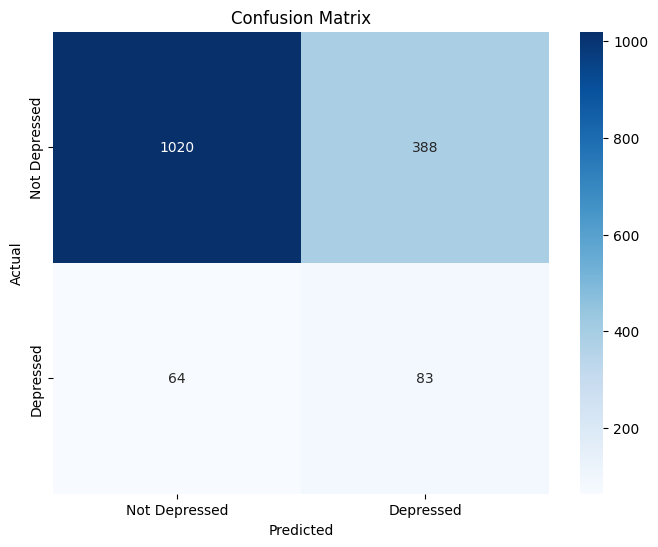

In [ ]:
# Bagging for DecisionTreeClassifier
bagging_dt = BaggingClassifier(base_estimator=best_dt_model, n_estimators=10, random_state=42)
bagging_dt.fit(X_train_preprocessed, y_train)
y_train_pred = bagging_dt.predict(X_train_preprocessed)
y_test_pred = bagging_dt.predict(X_test_preprocessed)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

adaboost_dt = AdaBoostClassifier(base_estimator=best_dt_model, n_estimators=50, random_state=42, algorithm='SAMME')
adaboost_dt.fit(X_train_preprocessed, y_train)
y_train_pred = adaboost_dt.predict(X_train_preprocessed)
y_test_pred = adaboost_dt.predict(X_test_preprocessed)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test Accuracy: 0.7768488745980707
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      5658
           1       0.26      0.71      0.38       559

    accuracy                           0.79      6217
   macro avg       0.61      0.76      0.63      6217
weighted avg       0.90      0.79      0.83      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1408
           1       0.24      0.62      0.34       147

    accuracy                           0.78      1555
   macro avg       0.60      0.71      0.60      1555
weighted avg       0.88      0.78      0.82      1555



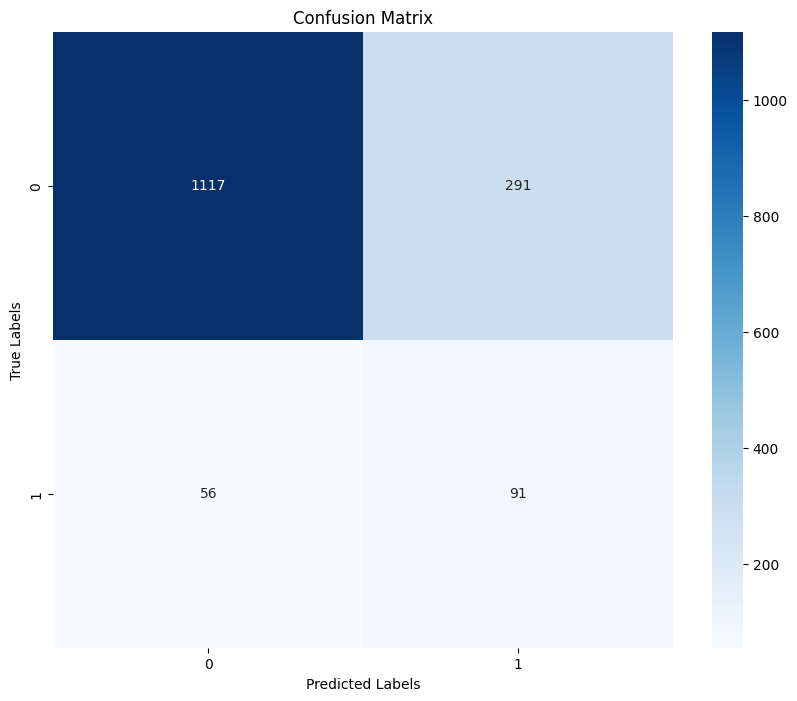

In [11]:
# Bagging for Logistic Regression
bagging_lr = BaggingClassifier(base_estimator=best_logistic_regression, n_estimators=10, random_state=42)
bagging_lr.fit(X_train_preprocessed, y_train)
y_train_pred = bagging_lr.predict(X_train_preprocessed)
y_test_pred = bagging_lr.predict(X_test_preprocessed)
test_accuracy = bagging_lr.score(X_test_preprocessed, y_test)
print("Test Accuracy:", test_accuracy)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      5658
           1       0.27      0.73      0.40       559

    accuracy                           0.80      6217
   macro avg       0.62      0.77      0.64      6217
weighted avg       0.91      0.80      0.84      6217

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1408
           1       0.23      0.59      0.33       147

    accuracy                           0.77      1555
   macro avg       0.59      0.69      0.60      1555
weighted avg       0.88      0.77      0.81      1555



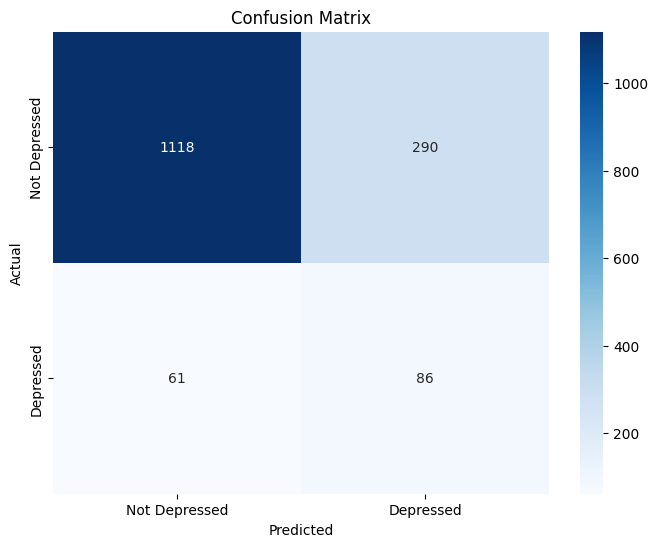

[[1.  0. ]
 [0.1 0.9]
 [0.2 0.8]
 ...
 [1.  0. ]
 [0.8 0.2]
 [0.2 0.8]]


In [ ]:
# Bagging for Support Vector Classifier
bagging_svc = BaggingClassifier(base_estimator=best_svc, n_estimators=10, random_state=42)
bagging_svc.fit(X_train_preprocessed, y_train)
y_train_pred = bagging_svc.predict(X_train_preprocessed)
y_test_pred = bagging_svc.predict(X_test_preprocessed)
y_test_pred_proba = bagging_svc.predict_proba(X_test_preprocessed)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(y_test_pred_proba)

In [ ]:
print("\nPercentage Prediction for Test Data:")
for i in range(len(X_test_preprocessed)):
    print(f"Row {i + 1}: Not depressed: {y_test_pred_proba[i, 0] * 100:.2f}%, Depressed: {y_test_pred_proba[i, 1] * 100:.2f}%")


Percentage Prediction for Test Data:
Row 1: Not depressed: 100.00%, Depressed: 0.00%
Row 2: Not depressed: 10.00%, Depressed: 90.00%
Row 3: Not depressed: 20.00%, Depressed: 80.00%
Row 4: Not depressed: 100.00%, Depressed: 0.00%
Row 5: Not depressed: 40.00%, Depressed: 60.00%
Row 6: Not depressed: 0.00%, Depressed: 100.00%
Row 7: Not depressed: 20.00%, Depressed: 80.00%
Row 8: Not depressed: 0.00%, Depressed: 100.00%
Row 9: Not depressed: 100.00%, Depressed: 0.00%
Row 10: Not depressed: 100.00%, Depressed: 0.00%
Row 11: Not depressed: 100.00%, Depressed: 0.00%
Row 12: Not depressed: 100.00%, Depressed: 0.00%
Row 13: Not depressed: 50.00%, Depressed: 50.00%
Row 14: Not depressed: 0.00%, Depressed: 100.00%
Row 15: Not depressed: 100.00%, Depressed: 0.00%
Row 16: Not depressed: 0.00%, Depressed: 100.00%
Row 17: Not depressed: 100.00%, Depressed: 0.00%
Row 18: Not depressed: 100.00%, Depressed: 0.00%
Row 19: Not depressed: 100.00%, Depressed: 0.00%
Row 20: Not depressed: 100.00%, Depresse

### Best Model - Logistic Regression (with Bagging)

In [13]:
# Logistic Regression with Bagging
y_proba = bagging_lr.predict_proba(X_pca)

print("\nPercentage Prediction for Test Data:")
for i in range(len(X_pca)):
    print(f"Row {i + 1}: Not depressed: {y_proba[i, 0] * 100:.2f}%, Depressed: {y_proba[i, 1] * 100:.2f}%")


Streaming output truncated to the last 5000 lines.
Row 2773: Not depressed: 78.29%, Depressed: 21.71%
Row 2774: Not depressed: 91.29%, Depressed: 8.71%
Row 2775: Not depressed: 91.89%, Depressed: 8.11%
Row 2776: Not depressed: 80.70%, Depressed: 19.30%
Row 2777: Not depressed: 87.31%, Depressed: 12.69%
Row 2778: Not depressed: 21.41%, Depressed: 78.59%
Row 2779: Not depressed: 45.74%, Depressed: 54.26%
Row 2780: Not depressed: 79.90%, Depressed: 20.10%
Row 2781: Not depressed: 56.10%, Depressed: 43.90%
Row 2782: Not depressed: 29.03%, Depressed: 70.97%
Row 2783: Not depressed: 85.18%, Depressed: 14.82%
Row 2784: Not depressed: 86.32%, Depressed: 13.68%
Row 2785: Not depressed: 10.51%, Depressed: 89.49%
Row 2786: Not depressed: 56.48%, Depressed: 43.52%
Row 2787: Not depressed: 76.90%, Depressed: 23.10%
Row 2788: Not depressed: 14.88%, Depressed: 85.12%
Row 2789: Not depressed: 81.44%, Depressed: 18.56%
Row 2790: Not depressed: 7.04%, Depressed: 92.96%
Row 2791: Not depressed: 70.96%, D

In [ ]:
import joblib

# Assuming 'bagging_lr' is your trained bagging logistic regression model
joblib.dump(bagging_lr, 'bagging_lr_model.pkl')